In [2]:
from ipynb.fs.full.Introduction import *
from tqdm import tqdm
import time

Note: I've been making some big additions to this section; all is WIP for the next day or so.

# Normalization Techniques

Within the literature, the typical approach to oversmoothing is to apply some type of normalization. To this end, we propose orthogonalizing out vector $\vec{q}$ from $X^{l}_{:,i}$ and then renormalizing each column. We incorporate additional scale parameters $0\leq{}s_{1}\leq{}1$ and $s_{2}$, which allow the model to "self-regulate" its own smoothness. 

$$X^{l}_{:,i} = X^{l}_{:,i} - s_{1}\frac{\vec{q}^{T}X^{l}_{:,i}}{||\vec{q}||_{2}^{2}}\vec{q}$$
$$X_{:,i}^{l} = s_{2}\frac{X_{:,i}^{l}}{||X_{:,i}^{l}||_{2}}$$

If $s_{1}=1$ and $\vec{q}=\vec{1}$, this is equivalent to PairNorm with individual scaling [16].

$$X_{:,i}^{l} = X_{:,i}^{l} - \frac{1}{n}\sum_{i=0}^{n}X_{:,i}^{l}$$
$$X_{:,i}^{l} = s \frac{X_{:,i}^{l}}{||X_{:,i}^{l}||_{2}}$$

In practice, we find that $\vec{q}$ should approximate the Hadamard inverse of the dominant eigenvector i.e $\vec{q}\approx{}v_{1}^{\circ{}-1}$ where $v_{1}^{\circ{}-1}\cdot{}v_{1} = n$ for $v_{1}\in{}R^{n}$. We conduct ablation studies for $\vec{q}=\vec{1}$,$\vec{q} = d_{degree}^{\circ{}-1}$, and $\vec{q}=v_{1}^{\circ{}-1}$ at $l_{max}=64$. Parameters are $s_{1}$ (grad-enabled vs. constant) and whether the network possesses 1-hop residual connections, which have been shown to improve the stability and performance of deeper GCNs [15]. The best model is then trained for all $l_{max}=1,2,4,...,64$. We also compare against both PairNorm and GraphSizeNorm [3].

## Dataset

See Section 4.1 for description/parameters.

In [3]:
num_graphs = 3000
d = []
for _ in range(num_graphs):
    # Set Cluster sizes and edge probabilities
    n = torch.randint(50,100,(5,))
    p = 1/(50*n) + (49/(50*n)) * torch.rand((5,5))
    p = .5 * (p + p.T)
    
    # Generate SBM
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    # Write to Data object
    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    
    # Compute Katz Centrality
    vals = torch.norm(torch.eig(adj.to_dense())[0],dim=1)
    v = 1/(1.01*vals.max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T) - torch.eye(adj.size(0)),dim=1)
    
    # Set as target
    G.y = y
    G.eig_max = vals.max()
    G.eig_min = vals.min()
    d[idx] = G
    
train,test = d[:2000],d[2000::]
train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

## Model

In [4]:
best_table = []

In [5]:
# Compute the Mean Average Distance of inputs
def batched_MAD(X,edge_index,edge_weights):
    X = X/torch.norm(X,dim=1)[:,None]
    cosine = 1 - torch.sum(X[edge_index[0]] * X[edge_index[1]],dim=1).abs()
    return 1/edge_weights.sum() * (edge_weights * cosine).sum()

# Compute the Aggregation Norm
def batched_agg(X,edge_index,edge_weights,batch):
    nX = torch_scatter.scatter_sum(edge_weights[:,None] * X[edge_index[1]], edge_index[0],dim=0)
    X,nX = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch],\
              nX/torch_scatter.scatter_sum(nX**2,batch,dim=0).sqrt()[batch]
    return torch.norm(X - nX,dim=1).mean()

# Compute normalized (absolute) rayleigh quotient
def rayleigh_quotient(X,edge_index,edge_weights,batch,eig_max,eig_min):
    num = torch_scatter.scatter_sum(X * torch_scatter.scatter_sum(edge_weights[:,None] * 
                                        X[edge_index[1]], edge_index[0],dim=0),
                                        batch, dim=0)
    denom = torch_scatter.scatter_sum(X**2,batch,dim=0)
    R = num/(denom)
    return torch.mean((eig_max[:,None] - R.abs())/(eig_max - eig_min)[:,None])

In [18]:
# Class for the OrthNorm
class OrthNorm(torch.nn.Module):
    def __init__(self,q,grad=True):
        super(OrthNorm,self).__init__()
        self.q = q

        # Scale parameters
        self.s1 = torch.nn.Parameter(torch.ones(1),requires_grad=grad)
        self.s2 = torch.nn.Parameter(torch.ones(1))

    def forward(self,X,edge_index,edge_weight,batch):
        
        # Compute q
        q = self.q(X,edge_index,edge_weight,batch)
        q_norm = torch_scatter.scatter_sum(q**2,batch,dim=0)
        
        # Compute scalar projection of X onto q
        alpha = torch_scatter.scatter_sum(X * q,batch,dim=0)/(q_norm)
        
        # Compute OrthNorm
        X = X - torch.sigmoid(self.s1) * (alpha)[batch] * q
        X = self.s2 * X/(torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt())[batch]
        return X

In [19]:
import torch
import torch_geometric
import torch_sparse
import torch_scatter

# This is a GraphConv model which we can plug various normalization schemes into.
class DummyModel(torch.nn.Module):
    def __init__(self,in_channels,int_channels,out_channels,depth,norm,q,grad=True,res=False):
        super(DummyModel,self).__init__()
        self.start = torch.nn.Linear(in_channels,int_channels)
        self.intermediate = torch.nn.ModuleList([torch.nn.ModuleList([torch.nn.Linear(int_channels,int_channels),\
                                                                      torch.nn.Linear(int_channels,int_channels)])\
                                                 for _ in range(depth)])
        self.norm = torch.nn.ModuleList([norm(q,grad) for _ in range(depth)])
        self.finish = torch.nn.Linear(int_channels,out_channels)
        self.res = res

    def forward(self,X,edge_index,edge_weight,batch):
        X = self.start(X)
        for idx,m in enumerate(self.intermediate):
            Update = m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)

            if self.res: X = X + Update
            else: X = Update

            X = torch.nn.LeakyReLU()(self.norm[idx](X,edge_index,edge_weight,batch))
            if torch.isnan(X).any(): raise ValueError
        return self.finish(X)

In [8]:
# A helper function to compute various metrics
def get_metrics(model,test_loader,k=64):

  # Layerwise MAD
  model_mad = []
    
  # Layerwise AggNorm
  model_agg = []
    
  # Normalized Rayleigh
  model_ray = []
    
  # S1 parameter
  model_s = []

  MAD,Agg,Ray,S = torch.zeros(k),torch.zeros(k),torch.zeros(k),torch.zeros(k)
    
  # Iterate over dataset and average metrics
  for idx,data in enumerate(test_loader):
        X = data.x.cuda()
        edge_index,edge_weight = data.edge_index.cuda(),data.edge_weight.cuda()
        batch = data.batch.cuda()

        model.eval()
        X = model.start(X)
        
        # Iterate over model layers
        for jdx,m in enumerate(model.intermediate):
            Update = m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)

            if model.res: X = X + Update
            else: X = Update
            X = torch.nn.LeakyReLU()(model.norm[idx](X,edge_index,edge_weight,batch))

            # Fetch S1
            S[jdx] += torch.sigmoid(model.norm[jdx].s1).item()
            
            # Compute MAD
            MAD[jdx] += batched_MAD(X,data.edge_index.cuda(),data.edge_weight.cuda()).mean().item()
            
            # Compute AggNorm
            Agg[jdx] += batched_agg(X,data.edge_index.cuda(),data.edge_weight.cuda(),batch).item()
            
            #Compute Normalized Rayleigh
            Ray[jdx] += rayleigh_quotient(X,edge_index,edge_weight,batch,data.eig_max.cuda(),data.eig_min.cuda()).mean().item()
        
  model_mad.append(MAD/(idx+1))
  model_agg.append(Agg/(idx+1))
  model_ray.append(Ray/(idx+1))
  model_s.append(S/(idx+1))

  # Return metrics
  return (model_mad,model_agg,model_ray,model_s)

## OrthNorm: $\vec{q} = \vec{1}$

In [9]:
# Compute ones vector
def identity(X,edge_index,edge_weight,batch):
    return torch.ones(X.shape[0]).cuda()[batch,None]

### Ablation Study

In [ ]:
graph_results = []
metrics = []

### Non-residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,identity).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

### Residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,identity,res=True).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Non-residual, no grad
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,identity,grad=False).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Residual, no grad
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,identity,res=True,grad=False).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

In [ ]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(4):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(4):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate(['NonRes,Grad','ResGrad','NonRes,NoGrad','Res,NoGrad']):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement. The defining factor appears to be whether $s_{1}$ is a trainable parameter; fixing it increases the L1 error by around an order of magnitude. Adding residual connections marginally hampers performance. In the NonRes,Grad case, we see significant improvement from the earlier $l=64$ model with batch normalization (see 4.1).

In [ ]:
for idx,l in enumerate(['NonRes,Grad','ResGrad','NonRes,NoGrad','Res,NoGrad']):
  plt.figure(figsize=(15,8))
  plt.subplot(1,3,1)
  plt.plot(metrics[idx][0][0],label='MAD')
  plt.xlabel('Layer')
  plt.ylabel('Mean Average Distance')

  plt.subplot(1,3,2)
  plt.plot(metrics[idx][1][0])
  plt.xlabel('Layer')
  plt.ylabel('Aggregation Norm')

  plt.subplot(1,3,3)
  plt.plot(metrics[idx][2][0])
  plt.xlabel('Layer')
  plt.ylabel('Normalized Rayleigh')

  plt.suptitle(l)
  plt.tight_layout()
  plt.show()

In general, all three of our metrics converge to smaller values when the $s_{1}$ gradient is enabled, which indicates that each $x_{i}$ is approaching $v_{1}$. We observe two regimes throughout the model layers; when $l<32$, metrics are relatively large, but, once $l\geq{}32$, they all drop sharply. This is most pronounced for AggNorm. Below we plot the trained values of $s_{1}$ vs. $l$ and see a similar pattern. $s_{1}$ oscillates between $.6$ and $.8$ for the first half of the model and then decays to $0.0$ in the final few layers. 

In [ ]:
plt.scatter(range(64),(metrics[0][-1][0]),label='NonRes,Grad',s=10)
plt.scatter(range(64),(metrics[1][-1][0]),label='Res,Grad',s=10)
plt.legend()
plt.ylabel('$s_{2}$')
plt.xlabel('Layer');

In [13]:
best_table.append([np.min(graph_results[i][1]) for i in range(4)])

## OrthNorm: $q = d_{degree}^{\circ{}-1}$

In [18]:
# Compute Hadamard Inverse of degree
def inverse_degree(X,edge_index,edge_weight,batch):
    degree = torch_geometric.utils.degree(edge_index[0]).cuda()[:,None]
    degree = degree/torch_scatter.scatter_sum(degree**2,batch,dim=0)[batch]
    return 1/degree

### Ablation Study

In [19]:
graph_results = []
metrics = []

### Non-residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,inverse_degree).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

### Residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,inverse_degree,res=True).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Non-residual, no grad
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,inverse_degree,grad=False).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Residual, no grad
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,inverse_degree,res=True,grad=False).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

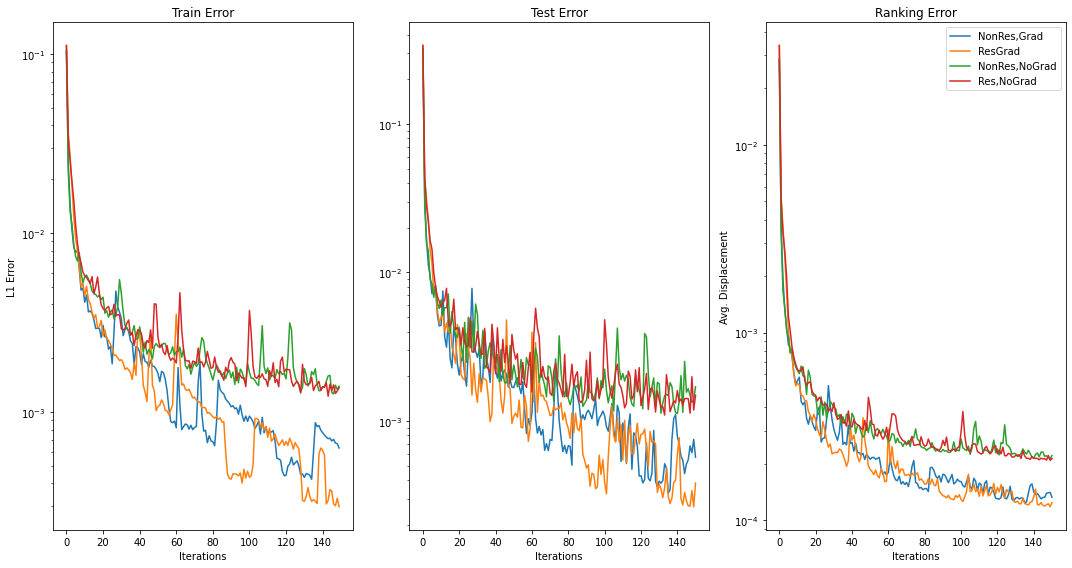

In [20]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(4):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(4):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate(['NonRes,Grad','ResGrad','NonRes,NoGrad','Res,NoGrad']):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement. Like with $\vec{q}=\vec{1}$, the greatest boost in performance comes from training with regards to $s_{1}$. We observe slightly better losses when the gradient is disabled, and adding residual connections offers further improvement in the gradient-enabled case. 

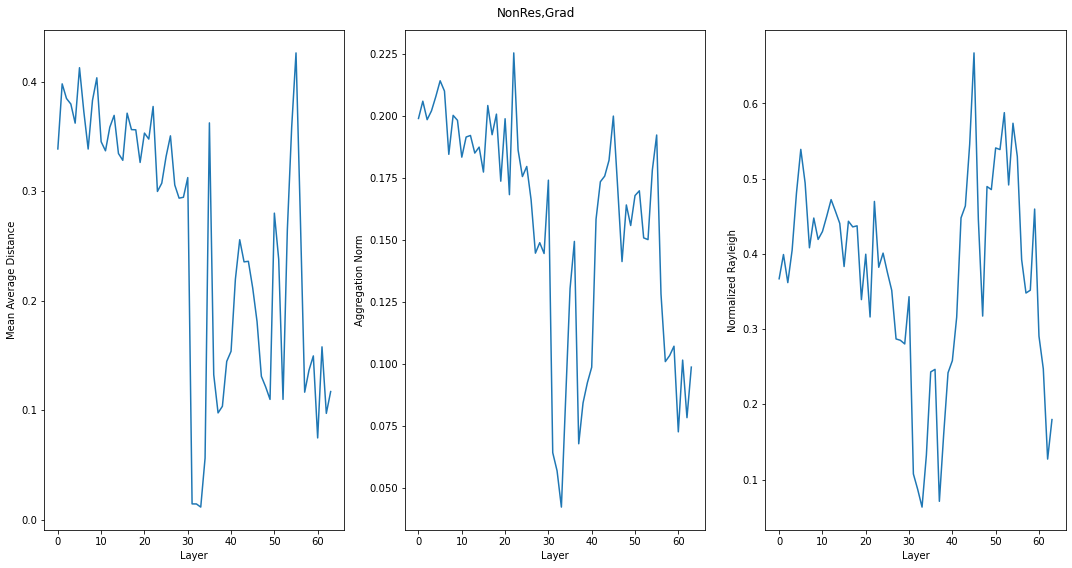

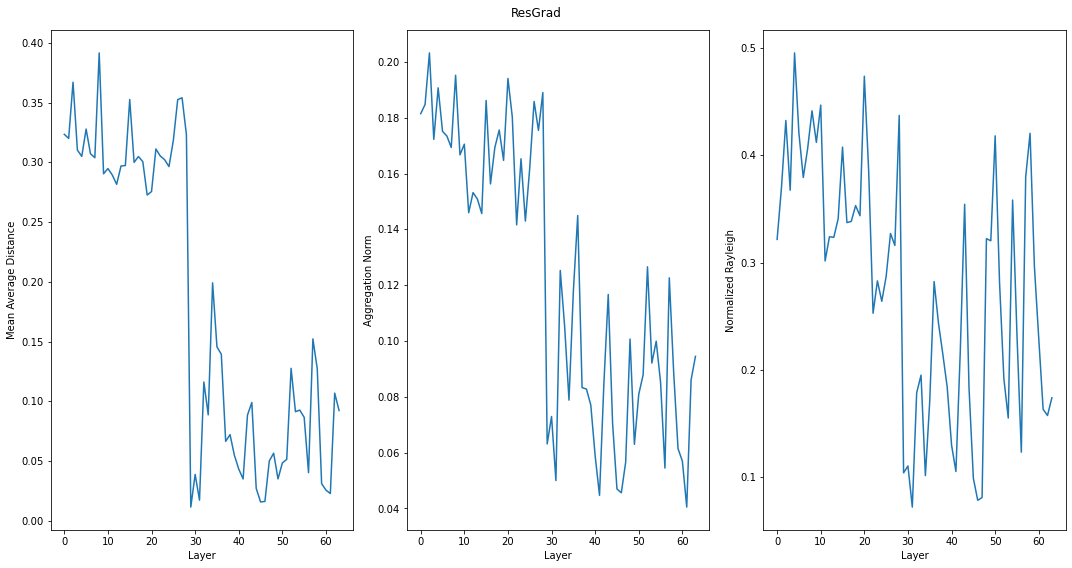

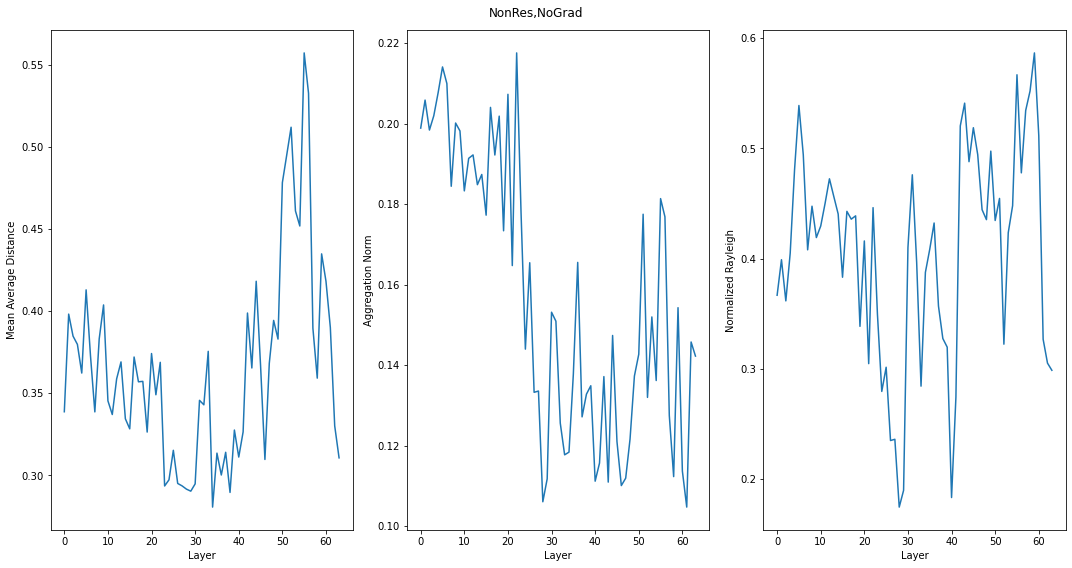

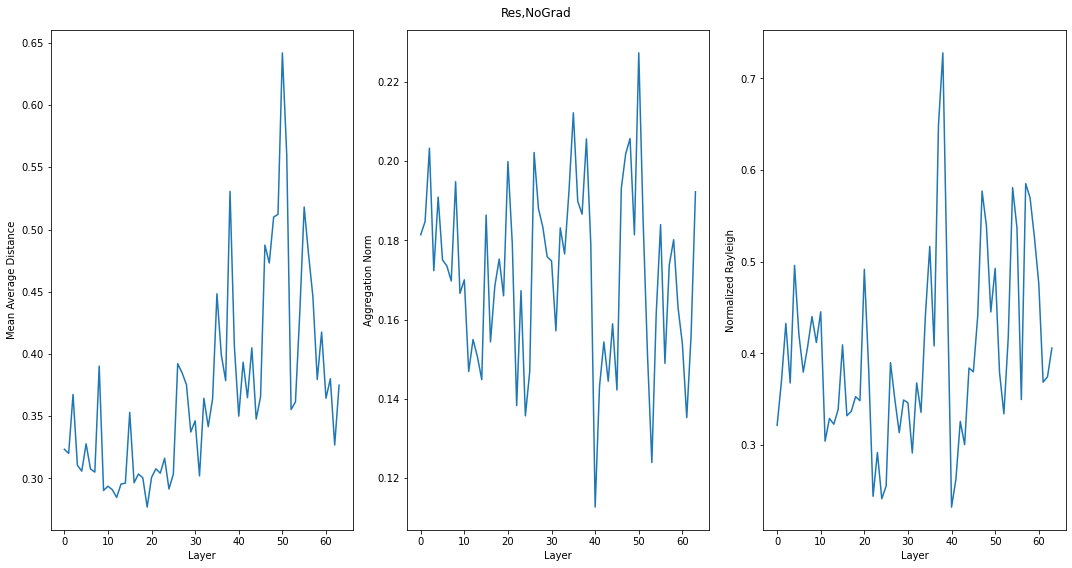

In [21]:
for idx,l in enumerate(['NonRes,Grad','ResGrad','NonRes,NoGrad','Res,NoGrad']):
  plt.figure(figsize=(15,8))
  plt.subplot(1,3,1)
  plt.plot(metrics[idx][0][0],label='MAD')
  plt.xlabel('Layer')
  plt.ylabel('Mean Average Distance')

  plt.subplot(1,3,2)
  plt.plot(metrics[idx][1][0])
  plt.xlabel('Layer')
  plt.ylabel('Aggregation Norm')

  plt.subplot(1,3,3)
  plt.plot(metrics[idx][2][0])
  plt.xlabel('Layer')
  plt.ylabel('Normalized Rayleigh')

  plt.suptitle(l)
  plt.tight_layout()
  plt.show()

There is still a defined jump in our metrics for the ResGrad model, whereas NonResGrad is more variable than before. Indeed, in the below figure, we see the $s_{1}$ values of the latter randomly spike during the $l\geq{}32$ regime.

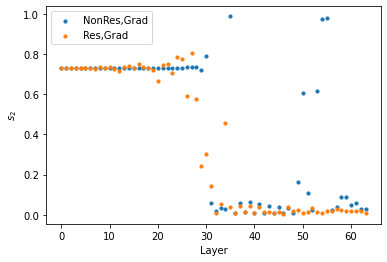

In [22]:
plt.scatter(range(64),(metrics[0][-1][0]),label='NonRes,Grad',s=10)
plt.scatter(range(64),(metrics[1][-1][0]),label='Res,Grad',s=10)
plt.legend()
plt.ylabel('$s_{2}$')
plt.xlabel('Layer');

In [23]:
best_table.append([np.min(graph_results[i][1]) for i in range(4)])

## OrthNorm: $q=v_{1}^{\circ{}-1}$

In [24]:
# Compute the Hadamard inverse of the approximate dominant eigenvector
def inverse_eig(X,edge_index,edge_weight,batch):
    with torch.no_grad():
        Z = torch.ones((X.shape[0],1)).cuda()
        for _ in range(20):
            Z = torch_scatter.scatter_sum(edge_weight[:,None] * Z[edge_index[1]], edge_index[0],dim=0)/10
        Z = Z/torch_scatter.scatter_sum(Z**2,batch,dim=0).sqrt()[batch]
        return 1/(1e-4 + Z)

### Ablation Study

In [25]:
graph_results = []
metrics = []

### Non-residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,inverse_eig).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

### Residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,inverse_eig,res=True).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Non-residual, no grad
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,inverse_eig,grad=False).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Residual, no grad
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,inverse_eig,res=True,grad=False).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

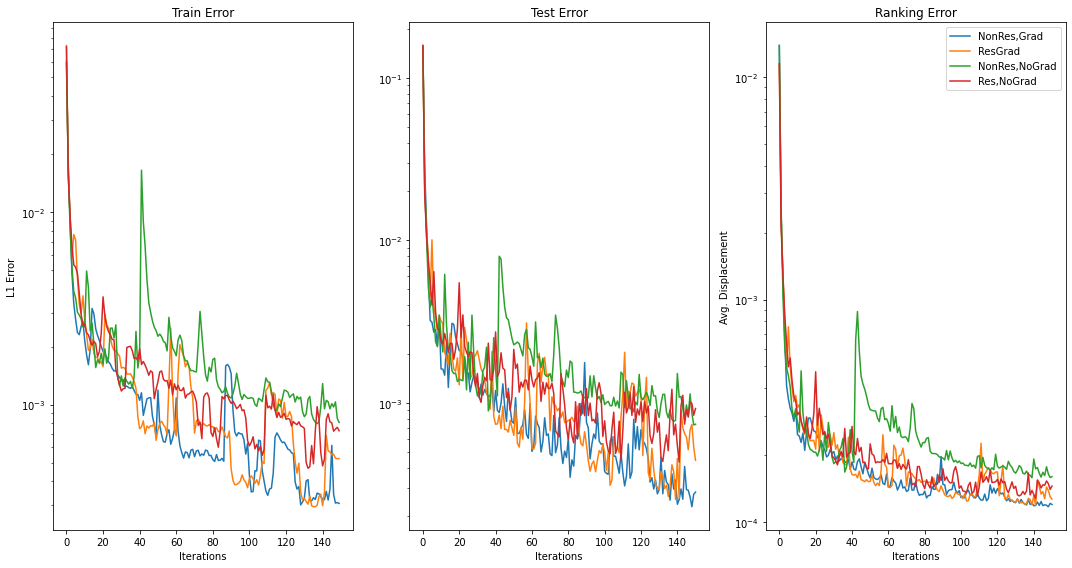

In [26]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(4):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(4):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate(['NonRes,Grad','ResGrad','NonRes,NoGrad','Res,NoGrad']):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement. Performance is further improved for gradient-disabled models, particularily when residual connections are also incorporated. NonRes,Gred converges to the lowest test loss.

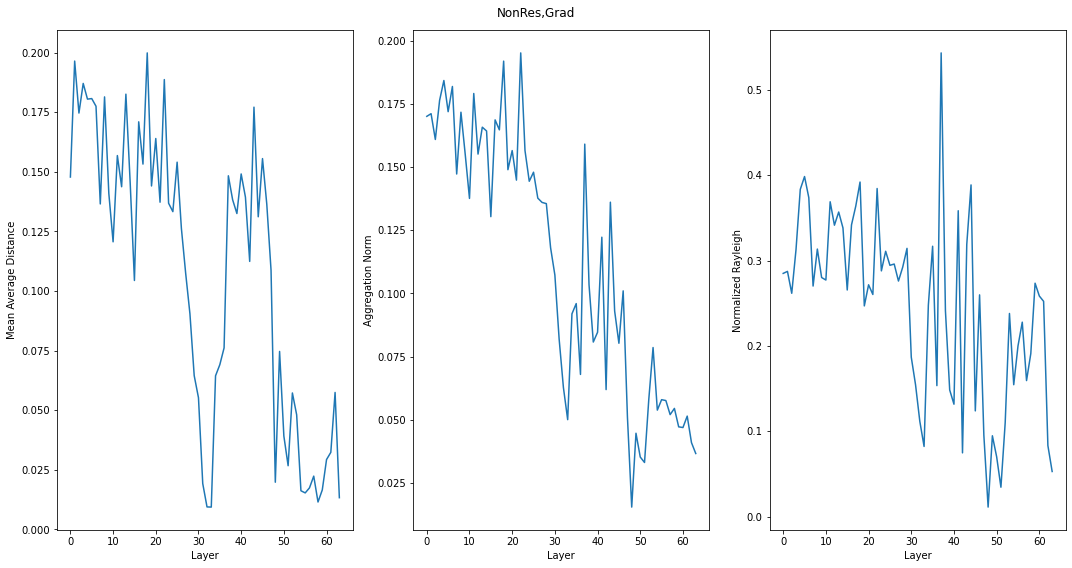

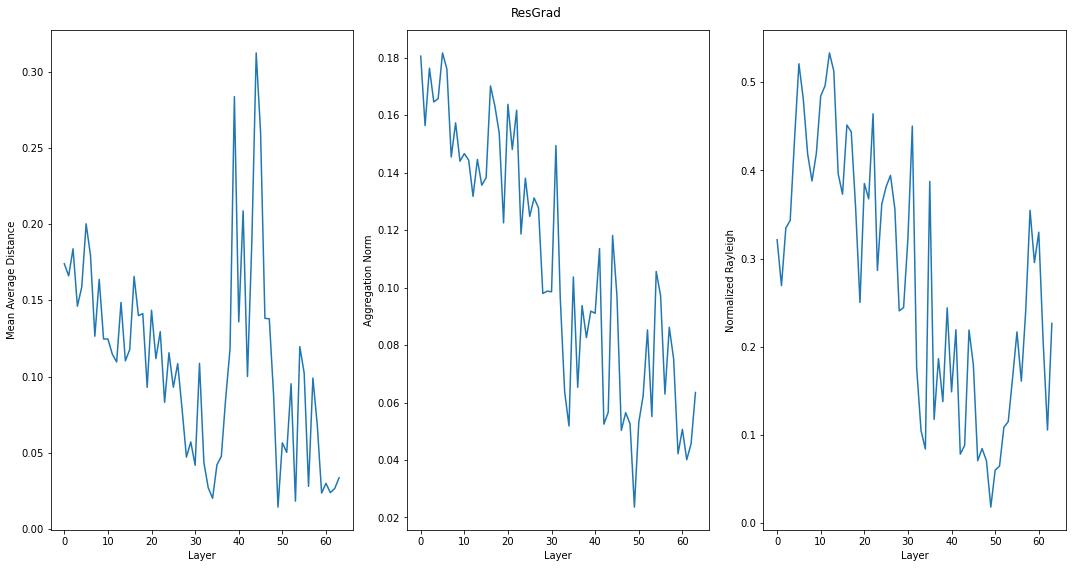

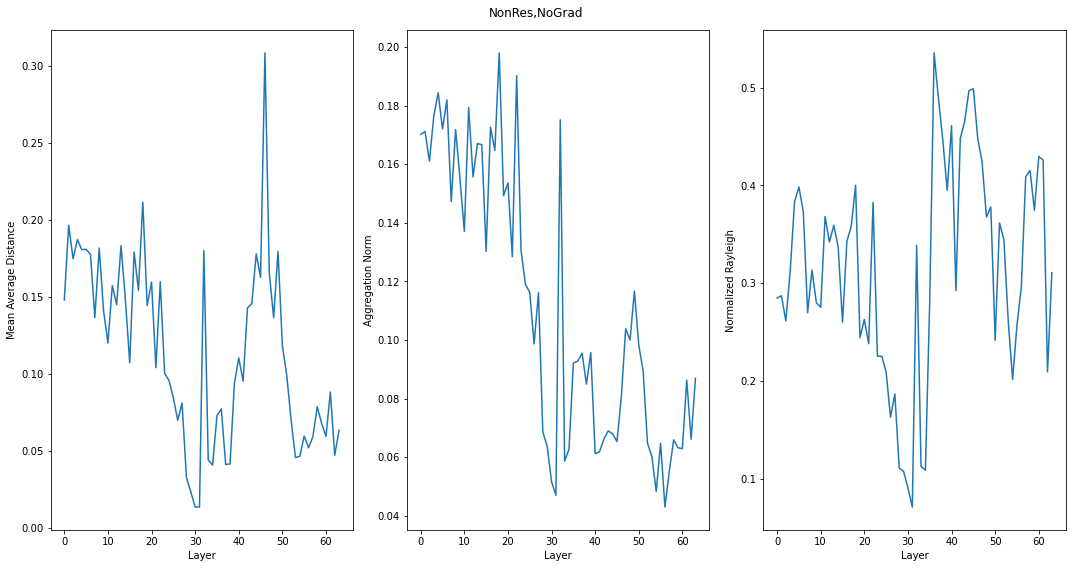

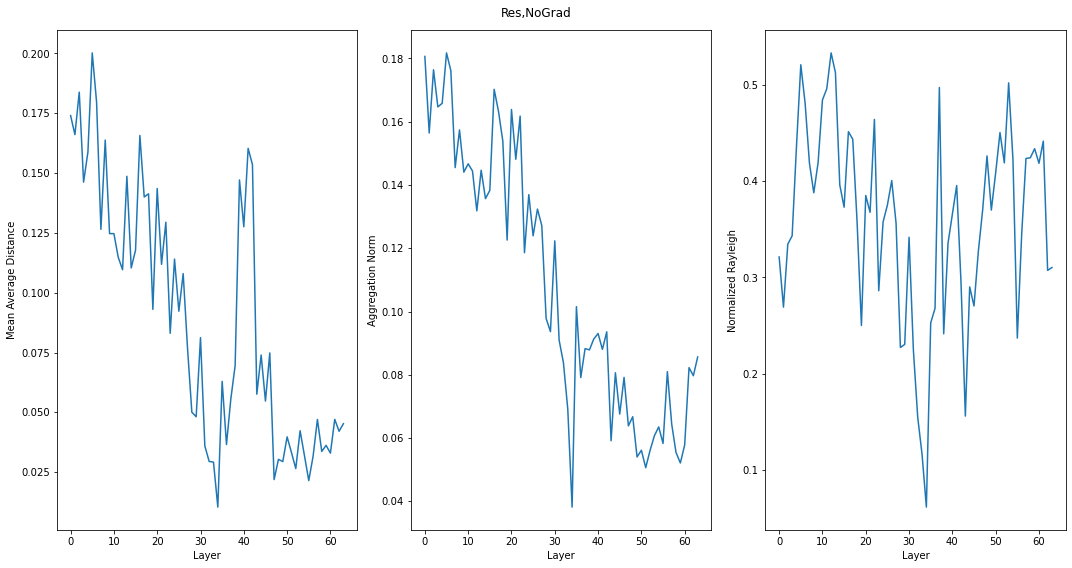

In [27]:
for idx,l in enumerate(['NonRes,Grad','ResGrad','NonRes,NoGrad','Res,NoGrad']):
  plt.figure(figsize=(15,8))
  plt.subplot(1,3,1)
  plt.plot(metrics[idx][0][0],label='MAD')
  plt.xlabel('Layer')
  plt.ylabel('Mean Average Distance')

  plt.subplot(1,3,2)
  plt.plot(metrics[idx][1][0])
  plt.xlabel('Layer')
  plt.ylabel('Aggregation Norm')

  plt.subplot(1,3,3)
  plt.plot(metrics[idx][2][0])
  plt.xlabel('Layer')
  plt.ylabel('Normalized Rayleigh')

  plt.suptitle(l)
  plt.tight_layout()
  plt.show()

Difference between regimes is less apparent, as our metrics are prone to large spikes shortly after $l=32$. AggNorm is the most informative of the three; it steadily declines, and, when ranked, its final values roughly correspond to the ordering of the models with regards to test loss. We still observe a clear partition in the $s_{1}$ (see below).

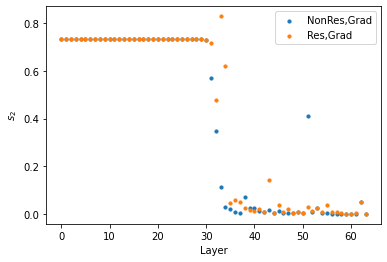

In [28]:
plt.scatter(range(64),(metrics[0][-1][0]),label='NonRes,Grad',s=10)
plt.scatter(range(64),(metrics[1][-1][0]),label='Res,Grad',s=10)
plt.legend()
plt.ylabel('$s_{2}$')
plt.xlabel('Layer');

In [29]:
best_table.append([np.min(graph_results[i][1]) for i in range(4)])

## OrthNorm: Best Model

In [30]:
import pandas as pd

table = pd.DataFrame(best_table)
table.columns = ['NonRes,Grad','ResGrad','NonRes,NoGrad','Res,NoGrad']
table.index = ['Ones','InverseDegree','InverseEig']
table

,"NonRes,Grad",ResGrad,"NonRes,NoGrad","Res,NoGrad"
Ones,0.000240,0.000293,0.002130,0.001970
InverseDegree,0.000326,0.000264,0.001121,0.001095
InverseEig,0.000229,0.000255,0.000732,0.000432


Across the board, the best results are obtained for $\vec{q}=v_{1}^{\circ{}-1}$. Difference between choices of $\vec{q}$ is minimal when $s_{1}$ is gradient-enabled, but otherwise $v_{1}^{\circ{}-1}$ offers noticably better performance. We find limited benefit to residual connections. Below, we train the NonRes,Grad model for all $l=1,2,4,...,64$ using the inverse approximate $v_{1}$.

In [31]:
graph_results = []
metrics = []

for k in [1,2,4,8,16,32,64]:
    torch.manual_seed(0)
    model = DummyModel(1,32,1,k,OrthNorm,inverse_eig,res=True).cuda()

    graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
    metrics.append(get_metrics(model,test_loader,k))

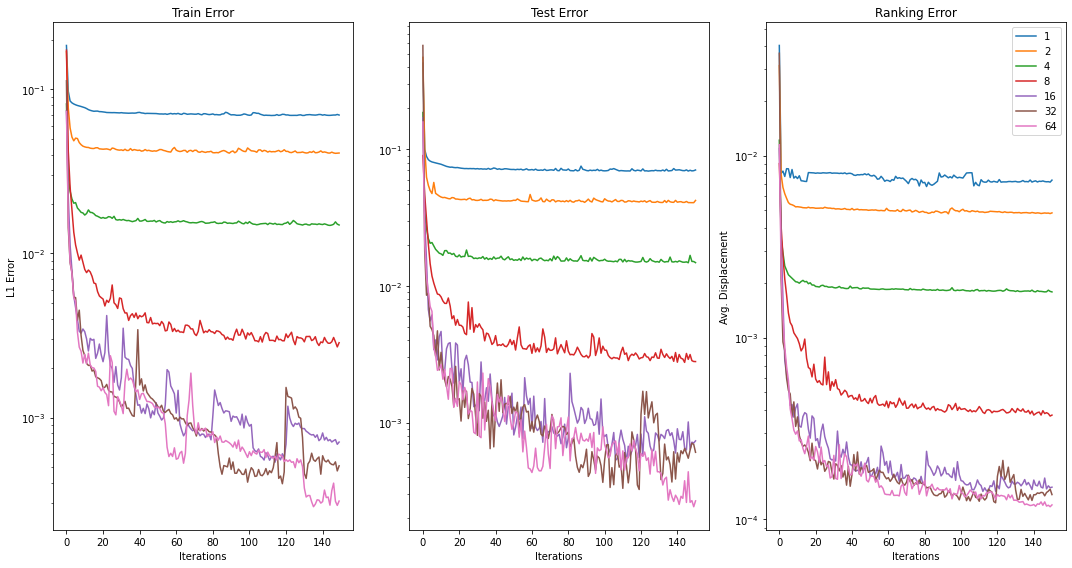

In [32]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(7):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(7):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate([1,2,4,8,16,32,64]):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement. All models for $l_{max}\geq{}8$ are improved versus the batch normalization case. 

## GraphSizeNorm

GraphSizeNorm is a computationally cheap normalization scheme defined by [3] as

$$X^{l} = \frac{X^{l}}{|V|}$$

This provides a useful benchmark without the added standardization of BatchNorm. We assess both residual and non-residual models at $l_{max}=64$

In [37]:
# Class for GraphSizeNorm. 
class GraphSizeNorm(torch.nn.Module):
    def __init__(self,q=None,grad=None):
        super(GraphSizeNorm,self).__init__()
        self.norm = torch_geometric.nn.GraphSizeNorm()
        self.s1 = torch.ones(1)
    def forward(self,X,edge_index,edge_weight,batch):
        return self.norm(X,batch)

### Ablation Study

In [38]:
graph_results = []
metrics = []

### Non-residual
torch.manual_seed(0)
model = DummyModel(1,32,1,64,GraphSizeNorm,None).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

### Residual
torch.manual_seed(0)
model = DummyModel(1,32,1,64,GraphSizeNorm,None,res=True).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

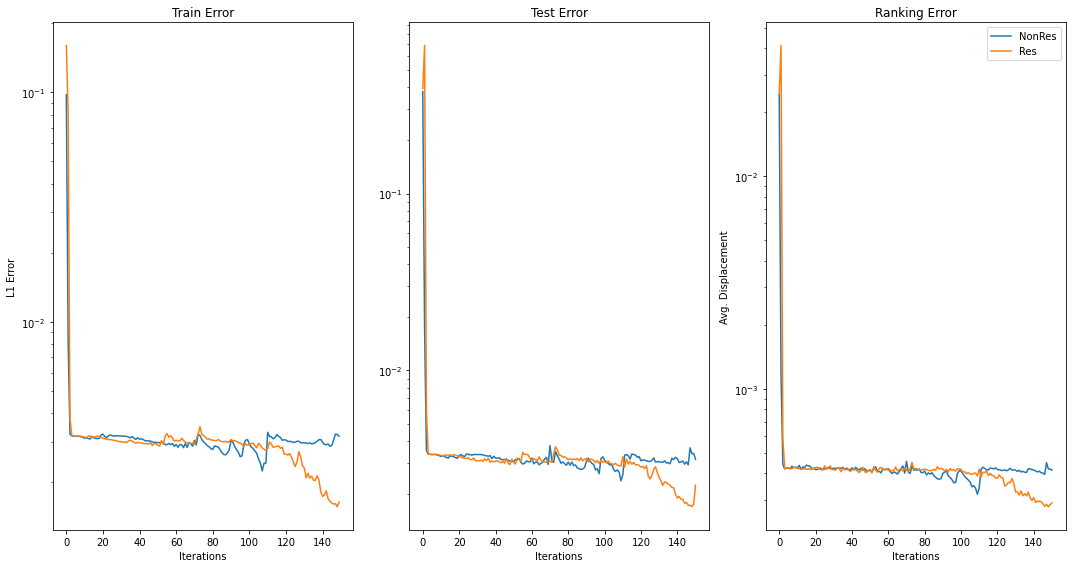

In [39]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(2):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(2):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate(['NonRes','Res']):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement. GraphSizeNorm improves over BatchNorm, but converges to a larger value than OrthNorm. Adding residual connections leads to minor improvement.

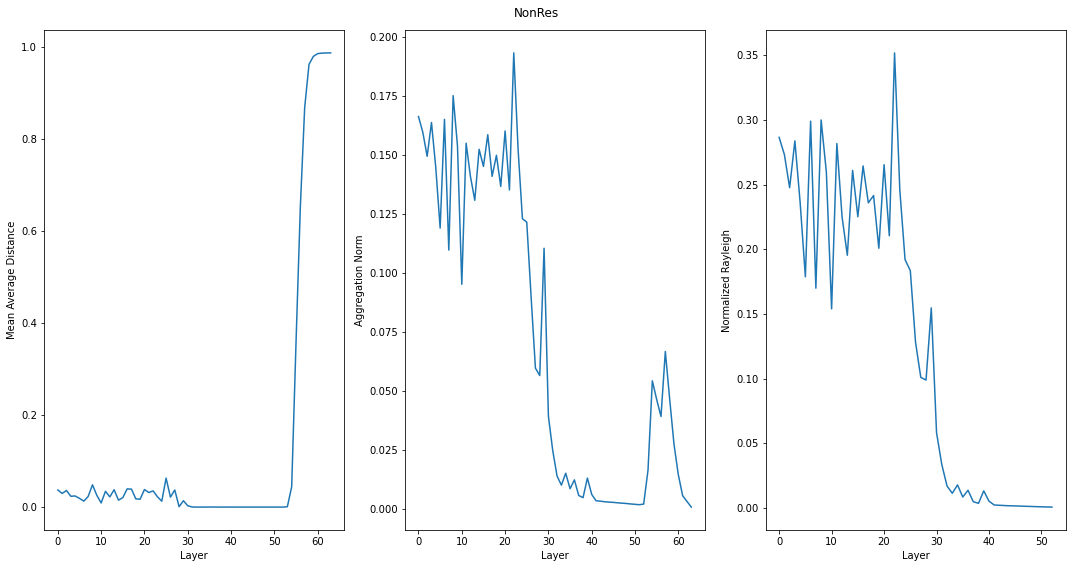

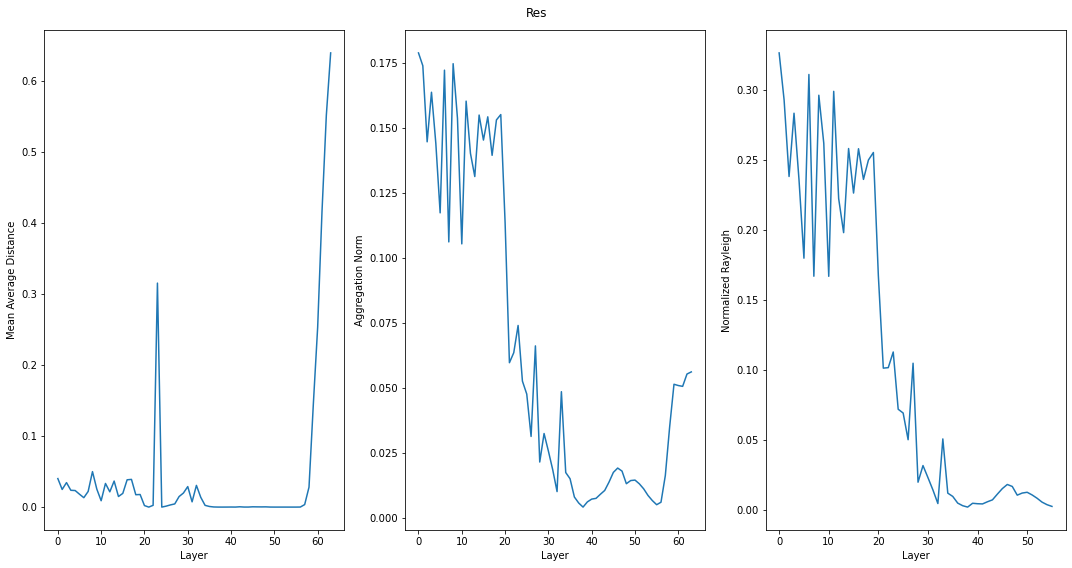

In [40]:
for idx,l in enumerate(['NonRes','Res']):
  plt.figure(figsize=(15,8))
  plt.subplot(1,3,1)
  plt.plot(metrics[idx][0][0],label='MAD')
  plt.xlabel('Layer')
  plt.ylabel('Mean Average Distance')

  plt.subplot(1,3,2)
  plt.plot(metrics[idx][1][0])
  plt.xlabel('Layer')
  plt.ylabel('Aggregation Norm')

  plt.subplot(1,3,3)
  plt.plot(metrics[idx][2][0])
  plt.xlabel('Layer')
  plt.ylabel('Normalized Rayleigh')

  plt.suptitle(l)
  plt.tight_layout()
  plt.show()

AggNorm and Normalized Rayleigh decay to around zero in both instances. However, the MAP skyrockets in the final few layers; this appears correlated with some small AggNorm spikes. Our model is thereby learning to do two somewhat contradictory things: produce individual node features $x_{i}$ which are nearly orthogonal to $x_{j}\forall{}j\in{}N_{i}^{1}$ and maintain $X_{:,i}\approx{}v_{1}$.

## PairNorm

We assess PairNorm (see 5.1) with both individual and global scaling, and resisual connections.

In [42]:
# PairNorm implementation
class PairNorm(torch.nn.Module):
    def __init__(self,q=None,grad=True):
        super(PairNorm,self).__init__()
        self.norm = torch_geometric.nn.PairNorm(scale_individually=grad)
        self.s1 = torch.ones(1)
    def forward(self,X,edge_index,edge_weight,batch):
        return self.norm(X,batch)

### Ablation Study

In [44]:
graph_results = []
metrics = []

### Non-residual, scale-individually
torch.manual_seed(0)
model = DummyModel(1,32,1,64,PairNorm,None).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

### Residual, scale-individually
torch.manual_seed(0)
model = DummyModel(1,32,1,64,PairNorm,None,res=True).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Non-residual
torch.manual_seed(0)
model = DummyModel(1,32,1,64,PairNorm,None,grad=False).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Residual
torch.manual_seed(0)
model = DummyModel(1,32,1,64,PairNorm,None,res=True,grad=False).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

### Results

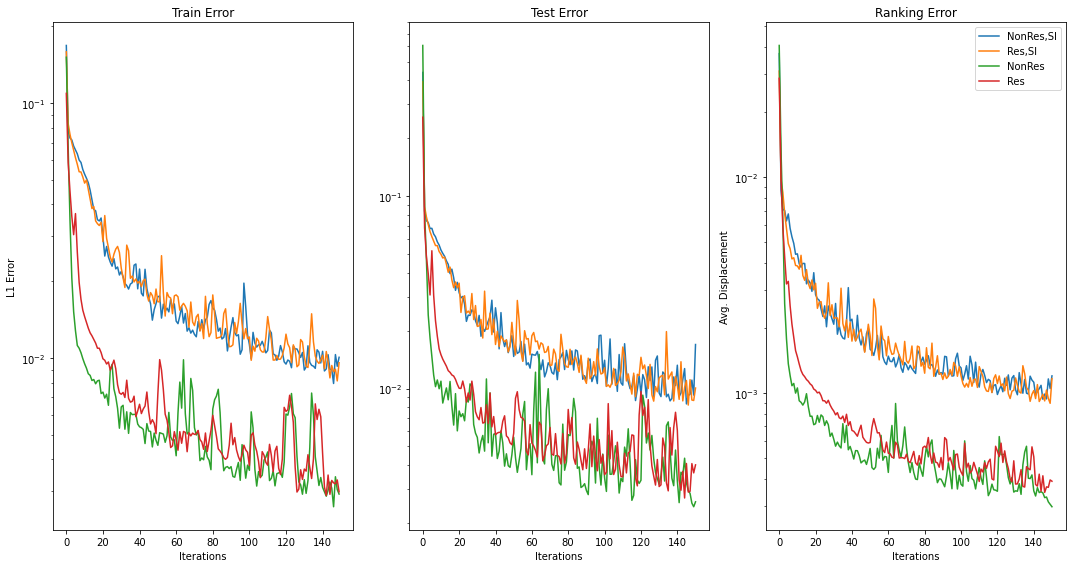

In [45]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(4):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(4):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate(['NonRes,SI','Res,SI','NonRes','Res']):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

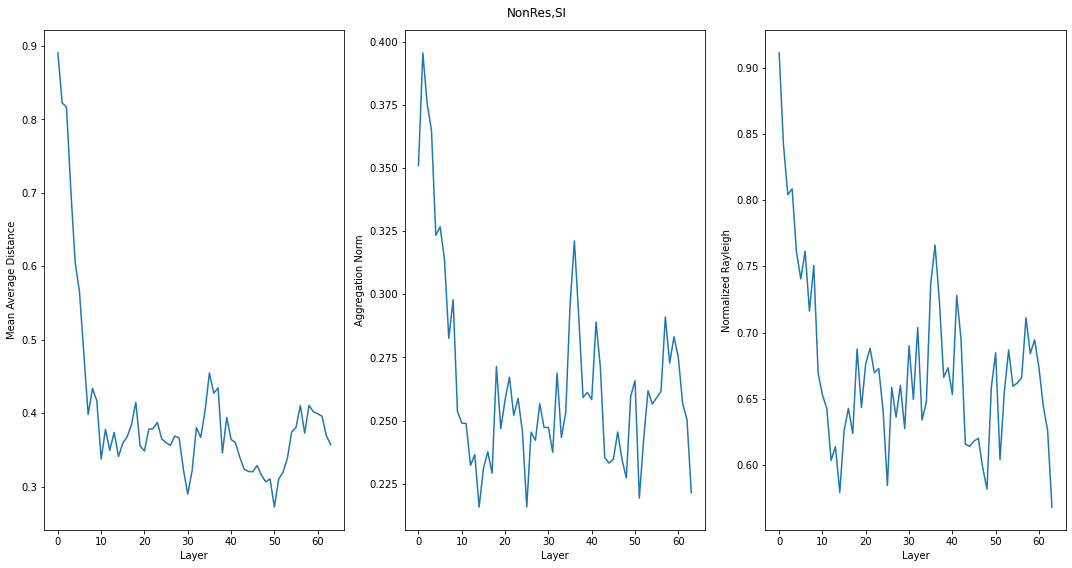

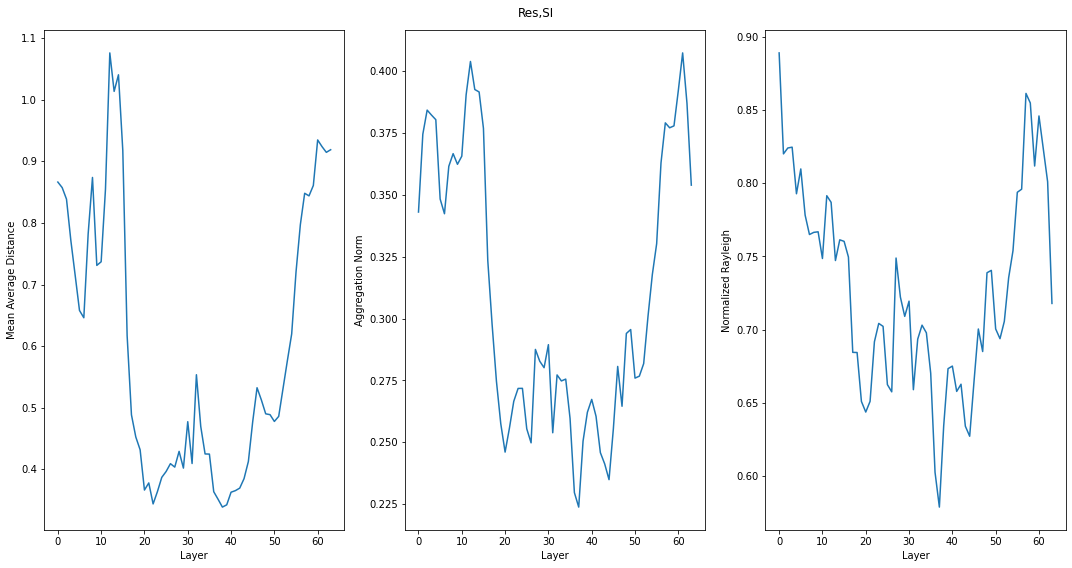

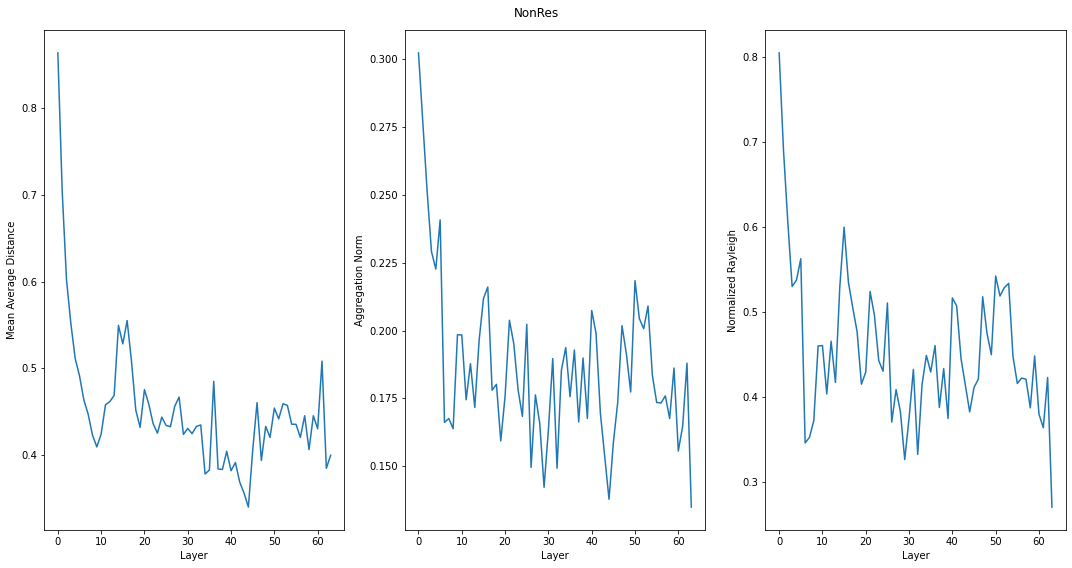

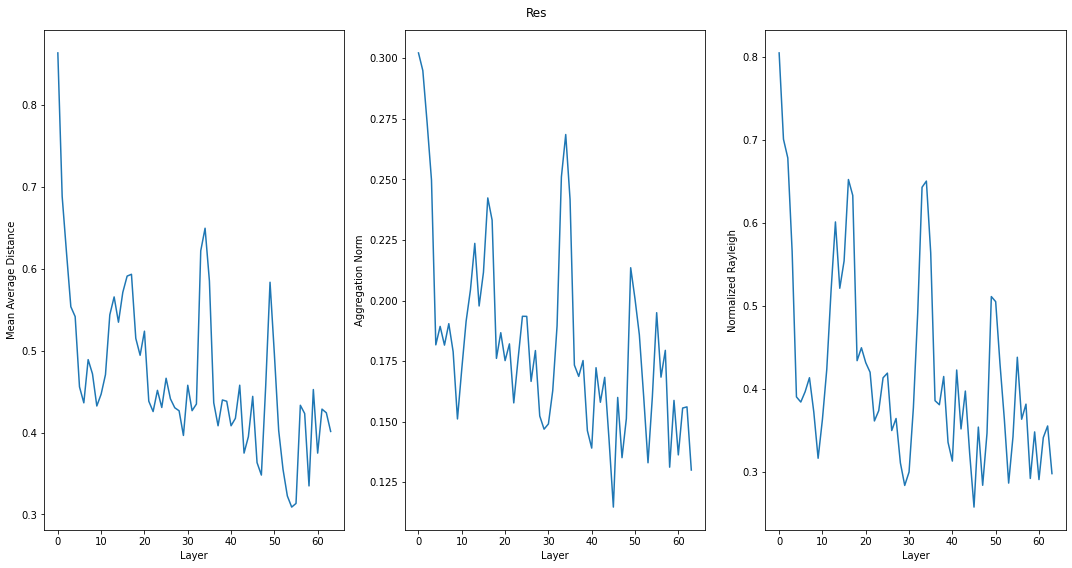

In [46]:
for idx,l in enumerate(['NonRes,SI','Res,SI','NonRes','Res']):
  plt.figure(figsize=(15,8))
  plt.subplot(1,3,1)
  plt.plot(metrics[idx][0][0],label='MAD')
  plt.xlabel('Layer')
  plt.ylabel('Mean Average Distance')

  plt.subplot(1,3,2)
  plt.plot(metrics[idx][1][0])
  plt.xlabel('Layer')
  plt.ylabel('Aggregation Norm')

  plt.subplot(1,3,3)
  plt.plot(metrics[idx][2][0])
  plt.xlabel('Layer')
  plt.ylabel('Normalized Rayleigh')

  plt.suptitle(l)
  plt.tight_layout()
  plt.show()

Our new normalization scheme, which we are calling OrthNorm (i.e Orthagonal Normalization, get it?), improves upon the unnormalized case, even without having fully converged. It surpasses PairNorm by around an order of magnitude given the same depth and number of epochs. We suspect this is because $d_{Katz}$ is close enough to $v_{1}$, and so PairNorm reduces the smoothness *too* much. Indeed, PairNorm returns large MAP and AggNorm values for each layer, whereas those of OrthNorm are generally smaller and more variable. This is due to $s_{1}$ regulating the magnitude of the orthogonalization; without it, MAP consistently hovers around $.20$ and StepAgg continually decreases. 